# **Monthly and hourly prediction of water flow:**
1. Machine Learning model
2. Deep Learning model

#Flow Forecasting Model

---



In [ ]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Hourly

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/aggregatedWholeHouse.csv')

# Convert the 'unix' timestamp to datetime
df['datetime'] = pd.to_datetime(df['unix'], unit='s')

# Aggregate data to hourly totals
hourly_data = df.resample('H', on='datetime').sum()

# Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Scale the 'flow' column
hourly_data['flow_scaled'] = scaler.fit_transform(hourly_data[['flow']])

# Calculate rolling features on the scaled 'flow'
hourly_data['rolling_mean'] = hourly_data['flow_scaled'].rolling(window=3).mean()
hourly_data['rolling_std'] = hourly_data['flow_scaled'].rolling(window=3).std()

# Lagged features on the scaled 'flow'
for lag in range(1, 3):
    hourly_data[f'lag_{lag}'] = hourly_data['flow_scaled'].shift(lag)

# Extract datetime features
hourly_data['hour_of_day'] = hourly_data.index.hour
hourly_data['day_of_week'] = hourly_data.index.dayofweek
hourly_data['week_of_month'] = (hourly_data.index.day - 1) // 7 + 1
hourly_data['month'] = hourly_data.index.month
hourly_data['year'] = hourly_data.index.year

# Drop the initial rows with NaN values due to rolling and lagging
hourly_data.dropna(inplace=True)

# Dataset for training
X_hourly = hourly_data[['rolling_mean', 'rolling_std', 'lag_1', 'lag_2', 'hour_of_day', 'day_of_week', 'week_of_month', 'month', 'year']]
y_hourly = hourly_data['flow_scaled']  # Using the scaled flow as the target variable

# Split into training and testing sets
X_train_hourly, X_test_hourly, y_train_hourly, y_test_hourly = train_test_split(
    X_hourly, y_hourly, test_size=0.2, random_state=42)

# Train the XGBoost model
model_hourly = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model_hourly.fit(X_train_hourly, y_train_hourly)

# Make predictions
predictions_hourly = model_hourly.predict(X_test_hourly)

# Evaluate the model
mae_hourly = mean_absolute_error(y_test_hourly, predictions_hourly)
print(f'Mean Absolute Error: {mae_hourly}')


Mean Absolute Error: 0.001962513866500794


In [ ]:
data_description = hourly_data['flow_scaled'].describe()
print(data_description)

count    15104.000000
mean         0.014233
std          0.056690
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: flow_scaled, dtype: float64


In [ ]:
# Compute metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test_hourly, predictions_hourly)
mse = mean_squared_error(y_test_hourly, predictions_hourly)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_hourly, predictions_hourly)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Absolute Error: 0.001962513866500794
Mean Squared Error: 0.00010680311431692054
Root Mean Squared Error: 0.01033455922218846
R-squared: 0.9691279492308575


Mean Absolute Error (MAE) of 0.0019625: This is a very low error, indicating that on average, the absolute difference between the predicted and actual values is very small. Given that the mean of your data is about 0.0142, this error is significantly lower, signifying high accuracy.

Mean Squared Error (MSE) of 0.0001068 and Root Mean Squared Error (RMSE) of 0.010335: Both of these metrics further affirm the low error of the model. The RMSE, being close to the MAE, also suggests that there are not many large errors skewing the data, which is a good sign.

R-squared of 0.9691: This value is very close to 1, indicating that your model explains approximately 96.91% of the variance in the target variable. This is an excellent result, showing that the model predictions are very close to the actual data points.

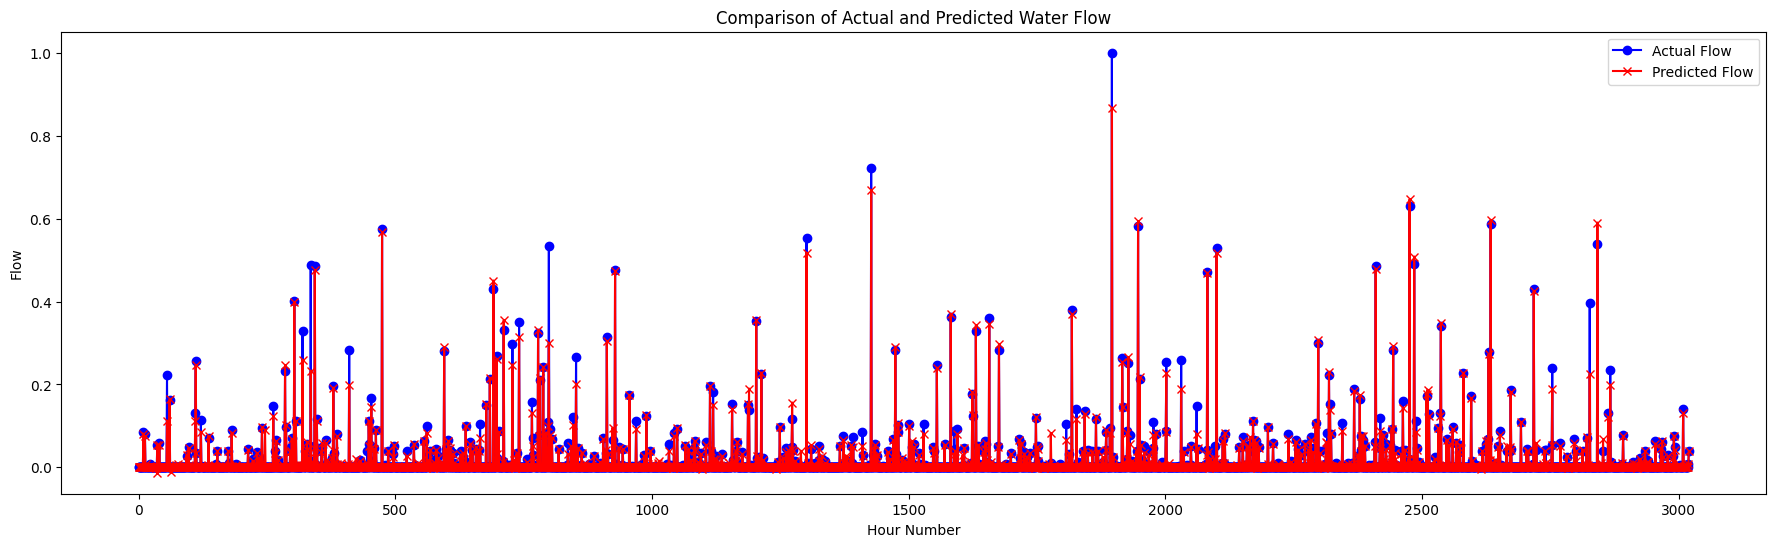

In [ ]:
import matplotlib.pyplot as plt

actual_values = y_test_hourly.to_numpy()

plt.figure(figsize=(22, 6))
plt.plot(actual_values, label='Actual Flow', marker='o', color='blue')
plt.plot(predictions_hourly, label='Predicted Flow', marker='x', color='red')

plt.title('Comparison of Actual and Predicted Water Flow')
plt.xlabel('Hour Number')  # Updated label for clarity
plt.ylabel('Flow')
plt.legend()
plt.show()

In [ ]:
# Sample input features
sample_input = {
    'rolling_mean': 1124.666667,    # Replace with an appropriate value
    'rolling_std': 	1756.730012,      # Replace with an appropriate value
    'lag_1': 3149.0,           # Flow from 1 hour ago
    'lag_2': 225.0,           # Flow from 2 hours ago
    'hour_of_day': 17,      # Hour of the day (0-23)
    'day_of_week': 1,       # Day of the week (0=Monday, 6=Sunday)
    'week_of_month': 3,     # Week of the month
    'month': 9,             # Month (1-12)
    'year': 2019            # Year
}

# Convert the sample input into a DataFrame
sample_input_df = pd.DataFrame([sample_input])

# Use the model to make a prediction
predicted_flow = model_hourly.predict(sample_input_df)

# Display the predicted flow
print("Predicted Hourly Flow:", predicted_flow[0],"mL")


Predicted Hourly Flow: 202.7071 mL


This sample prediction demonstrates the model's capability to assist users in forecasting hourly water usage. It offers a practical tool for anticipating consumption for a specified hour, enhancing resource planning and management.

# Deep Learning:

Loading the data:

In [ ]:
import pandas as pd

# Load your dataset
# Replace 'your_data.csv' with the path to your data file
aggregated_data = pd.read_csv('/content/drive/MyDrive/Deep_Learning/Water_Whole_House/aggregatedWholeHouse.csv')

# Convert your datetime column to pandas datetime object
# Replace 'datetime_column' with your actual datetime column name
# aggregated_data['datetime'] = pd.to_datetime(aggregated_data['unix'])
aggregated_data.shape

(166082, 2)

Data description:

In [ ]:
# Convert Unix timestamps to datetime
aggregated_data['datetime'] = pd.to_datetime(aggregated_data['unix'], unit='s')

# Drop the original 'unix' column as it's no longer needed
aggregated_data.drop(columns='unix', inplace=True)

# Move 'datetime' column to the first position
aggregated_data = aggregated_data[['datetime', 'flow']]

# Inspect the updated dataset and basic statistics of the 'flow' column
updated_aggregated_data_head = aggregated_data.head()
flow_statistics = aggregated_data['flow'].describe()

(updated_aggregated_data_head, flow_statistics)


(             datetime   flow
 0 2019-02-13 08:57:09    0.0
 1 2019-02-13 08:59:32  177.0
 2 2019-02-13 09:03:32    0.0
 3 2019-02-13 09:08:32    0.0
 4 2019-02-13 09:13:32    0.0,
 count    166082.000000
 mean        138.141072
 std         656.585100
 min           0.000000
 25%           0.000000
 50%           0.000000
 75%           0.000000
 max       20052.000000
 Name: flow, dtype: float64)

Plotting outliers:

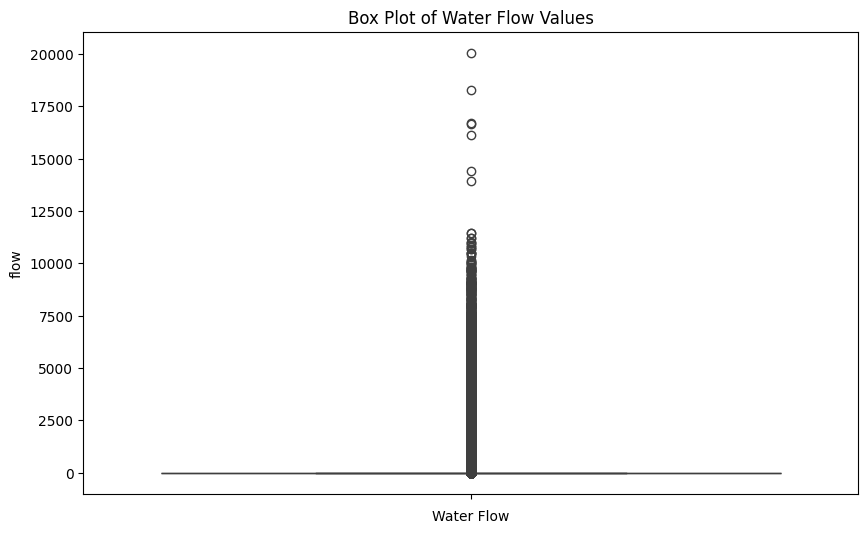

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizing the distribution of 'flow' values to identify outliers
plt.figure(figsize=(10, 6))
sns.boxplot(aggregated_data['flow'])
plt.title('Box Plot of Water Flow Values')
plt.xlabel('Water Flow')
plt.show()



Splitting the dataset on a date:

In [ ]:
def split_time_series_data(df, split_date):

    train = df.loc[df.index <split_date]
    test = df.loc[df.index >= split_date]

    return train, test

In [ ]:
# Aggregating data on a daily basis
daily_aggregated_data = aggregated_data.resample('H', on='datetime').sum().reset_index()

# Display the first few rows of the daily aggregated data
print(daily_aggregated_data.shape)

print(daily_aggregated_data['datetime'].min())
print(daily_aggregated_data['datetime'].max())

(15106, 2)
2019-02-13 08:00:00
2020-11-03 17:00:00


In [ ]:
daily_aggregated_data.head()

,datetime,flow
0,2019-02-13 08:00:00,177.0
1,2019-02-13 09:00:00,0.0
2,2019-02-13 10:00:00,0.0
3,2019-02-13 11:00:00,402.0
4,2019-02-13 12:00:00,0.0


Feature Engineering:

In [ ]:
# Feature Engineering
# Time-based features
daily_aggregated_data['hr_of_day'] = daily_aggregated_data['datetime'].dt.hour
daily_aggregated_data['day_of_week'] = daily_aggregated_data['datetime'].dt.dayofweek
daily_aggregated_data['weekend'] = daily_aggregated_data['day_of_week'].apply(lambda x: 1 if x > 4 else 0)
daily_aggregated_data['month'] = daily_aggregated_data['datetime'].dt.month
daily_aggregated_data['year'] = daily_aggregated_data['datetime'].dt.year

# Rolling window features (adjust the window size as needed)
daily_aggregated_data['rolling_mean'] = daily_aggregated_data['flow'].rolling(window=3).mean()
daily_aggregated_data['rolling_std'] = daily_aggregated_data['flow'].rolling(window=3).std()
daily_aggregated_data.dropna(inplace=True)

Lags:

In [ ]:

# test_data.reset_index(inplace=True)
def create_lags(data,lags=4):
    df_copy = data.copy()
    for i in range(1,lags):

      df_copy[f'lag_{i}'] = df_copy['flow'].shift(i)
      df_copy.dropna(inplace=True)
    return df_copy

daily_aggregated_data = create_lags(daily_aggregated_data)
# test_data_lag = create_lags(test_data)

In [ ]:
daily_aggregated_data.shape

(15098, 12)

In [ ]:
daily_aggregated_data

,datetime,flow,hr_of_day,day_of_week,weekend,month,year,rolling_mean,rolling_std,lag_1,lag_2,lag_3
8,2019-02-13 16:00:00,0.0,16,2,0,2,2019,0.0,0.000000,0.0,0.0,0.0
9,2019-02-13 17:00:00,0.0,17,2,0,2,2019,0.0,0.000000,0.0,0.0,0.0
10,2019-02-13 18:00:00,0.0,18,2,0,2,2019,0.0,0.000000,0.0,0.0,0.0
11,2019-02-13 19:00:00,0.0,19,2,0,2,2019,0.0,0.000000,0.0,0.0,0.0
12,2019-02-13 20:00:00,0.0,20,2,0,2,2019,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
15101,2020-11-03 13:00:00,0.0,13,1,0,11,2020,0.0,0.000000,0.0,0.0,0.0
15102,2020-11-03 14:00:00,0.0,14,1,0,11,2020,0.0,0.000000,0.0,0.0,0.0
15103,2020-11-03 15:00:00,0.0,15,1,0,11,2020,0.0,0.000000,0.0,0.0,0.0
15104,2020-11-03 16:00:00,6.0,16,1,0,11,2020,2.0,3.464102,0.0,0.0,0.0


In [ ]:
daily_aggregated_data_with_lags = daily_aggregated_data.set_index('datetime')

# Specify the split date
split_date = pd.Timestamp('2020-06-01')

# Split the data
train_data, test_data = split_time_series_data(daily_aggregated_data_with_lags, split_date)

print("Training Data:")
print(train_data.head())
print("\nTesting Data:")
print(test_data.head())


Training Data:
                     flow  hr_of_day  day_of_week  weekend  month  year  \
datetime                                                                  
2019-02-13 16:00:00   0.0         16            2        0      2  2019   
2019-02-13 17:00:00   0.0         17            2        0      2  2019   
2019-02-13 18:00:00   0.0         18            2        0      2  2019   
2019-02-13 19:00:00   0.0         19            2        0      2  2019   
2019-02-13 20:00:00   0.0         20            2        0      2  2019   

                     rolling_mean  rolling_std  lag_1  lag_2  lag_3  
datetime                                                             
2019-02-13 16:00:00           0.0          0.0    0.0    0.0    0.0  
2019-02-13 17:00:00           0.0          0.0    0.0    0.0    0.0  
2019-02-13 18:00:00           0.0          0.0    0.0    0.0    0.0  
2019-02-13 19:00:00           0.0          0.0    0.0    0.0    0.0  
2019-02-13 20:00:00           0.0      

In [ ]:
print(train_data.shape)
print(test_data.shape)

(11360, 11)
(3738, 11)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

X_train= pd.DataFrame(train_data.drop(columns=['flow']))
y_train=train_data[['flow']]

X_test=test_data.drop(columns=['flow'])
y_test=test_data[['flow']]



In [ ]:
X_train=X_train.reset_index()
X_test=X_test.reset_index()


In [ ]:
X_train=X_train.drop(columns=['datetime'], axis=1)
X_test=X_test.drop(columns=['datetime'], axis=1)

In [ ]:
X_train

,hr_of_day,day_of_week,weekend,month,year,rolling_mean,rolling_std,lag_1,lag_2,lag_3
0,16,2,0,2,2019,0.0,0.0,0.0,0.0,0.0
1,17,2,0,2,2019,0.0,0.0,0.0,0.0,0.0
2,18,2,0,2,2019,0.0,0.0,0.0,0.0,0.0
3,19,2,0,2,2019,0.0,0.0,0.0,0.0,0.0
4,20,2,0,2,2019,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
11355,19,6,1,5,2020,0.0,0.0,0.0,0.0,0.0
11356,20,6,1,5,2020,0.0,0.0,0.0,0.0,0.0
11357,21,6,1,5,2020,0.0,0.0,0.0,0.0,0.0
11358,22,6,1,5,2020,0.0,0.0,0.0,0.0,0.0


Normalise the data:

In [ ]:

## Normalizing the features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

scaler_Y = MinMaxScaler()

# Note: Y.reshape(-1, 1) is used to transform Y into a 2D array for fitting, assuming Y is a 1D array
y_train_scaled = scaler_Y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_Y.transform(y_test.values.reshape(-1, 1))




In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

sequence_length = 1
batch_size = 32

## Creating time series data
train_generator = TimeseriesGenerator(X_train_scaled, y_train_scaled, length=sequence_length, batch_size=batch_size)
val_generator = TimeseriesGenerator(X_test_scaled, y_test_scaled, length=sequence_length, batch_size=batch_size)




In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout

# sequence_length=24
n_features = X_train.shape[1]  # Number of features in the dataset

model = Sequential()

# First LSTM layer
model.add(LSTM(units=100, activation='relu', return_sequences=True, input_shape=(sequence_length,n_features)))

# # Second LSTM layer
# # Note that you don't need to specify input_shape for subsequent layers
# model.add(LSTM(units=50, activation='relu'))

# Output layer
# For regression tasks, units=1. For classification, units should match the number of classes
model.add(Dense(units=1))

# Compile the model
# Use 'mse' for regression tasks. For binary classification, use 'binary_crossentropy'.
# For multi-class classification, use 'categorical_crossentropy'.

model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model.fit(train_generator, validation_data = val_generator, epochs=500)


Epoch 1/500
355/355 [==============================] - 4s 5ms/step - loss: 0.0023 - val_loss: 0.0059
Epoch 2/500
355/355 [==============================] - 1s 4ms/step - loss: 0.0023 - val_loss: 0.0059
Epoch 3/500
355/355 [==============================] - 1s 4ms/step - loss: 0.0022 - val_loss: 0.0058
Epoch 4/500
355/355 [==============================] - 1s 4ms/step - loss: 0.0022 - val_loss: 0.0061
Epoch 5/500
355/355 [==============================] - 1s 4ms/step - loss: 0.0022 - val_loss: 0.0060
Epoch 6/500
355/355 [==============================] - 3s 7ms/step - loss: 0.0022 - val_loss: 0.0060
Epoch 7/500
355/355 [==============================] - 1s 4ms/step - loss: 0.0022 - val_loss: 0.0056
Epoch 8/500
355/355 [==============================] - 1s 4ms/step - loss: 0.0022 - val_loss: 0.0060
Epoch 9/500
355/355 [==============================] - 1s 4ms/step - loss: 0.0022 - val_loss: 0.0056
Epoch 10/500
355/355 [==============================] - 1s 3ms/step - loss: 0.0022 - val_lo

In [ ]:
# Assuming you have a test_generator similar to train_generator
test_loss = model.evaluate(val_generator)
print(f"Test Loss: {test_loss}")


117/117 [==============================] - 0s 2ms/step - loss: 0.0058
Test Loss: 0.005847033113241196


In [ ]:
# Save the model in SavedModel format
model.save('/content/drive/MyDrive/Deep_Learning/DL_Model.h5')  # The model is saved in a directory 'my_saved_model/'


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Make predictions on the test set
y_pred = model.predict(val_generator)


 # This reshapes the array to 2D if you have multiple features
 # Flatten 'y_pred' to a 1D array if it is 3D [samples, timesteps, features]
# This is assuming you have one feature and are interested in the last time step prediction
if y_pred.ndim == 3:
    y_pred = y_pred[:, -1, 0]  # This selects the last timestep and the first feature

y_val_aligned = y_test_scaled[:len(y_pred)]

# Calculate R^2 score
r2 = r2_score(y_val_aligned, y_pred)

# Calculate mean squared error
mse = mean_squared_error(y_val_aligned, y_pred)

# Calculate mean absolute error
mae = mean_absolute_error(y_val_aligned, y_pred)

print("R^2 Score:", r2)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

117/117 [==============================] - 0s 2ms/step
R^2 Score: 0.0752603983543293
Mean Squared Error: 0.00520572031716428
Mean Absolute Error: 0.0290973066973087


Simple LSTM:

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout
n_features = X_train.shape[1]  # Number of features in the dataset
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, n_features)),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

model.fit(train_generator, validation_data = val_generator, epochs=50)


Epoch 1/50
355/355 [==============================] - 6s 12ms/step - loss: 0.0032 - val_loss: 0.0058
Epoch 2/50
355/355 [==============================] - 3s 9ms/step - loss: 0.0023 - val_loss: 0.0056
Epoch 3/50
355/355 [==============================] - 3s 7ms/step - loss: 0.0023 - val_loss: 0.0060
Epoch 4/50
355/355 [==============================] - 4s 11ms/step - loss: 0.0023 - val_loss: 0.0063
Epoch 5/50
355/355 [==============================] - 3s 8ms/step - loss: 0.0022 - val_loss: 0.0061
Epoch 6/50
355/355 [==============================] - 2s 7ms/step - loss: 0.0022 - val_loss: 0.0063
Epoch 7/50
355/355 [==============================] - 3s 9ms/step - loss: 0.0022 - val_loss: 0.0062
Epoch 8/50
355/355 [==============================] - 3s 9ms/step - loss: 0.0022 - val_loss: 0.0057
Epoch 9/50
355/355 [==============================] - 3s 7ms/step - loss: 0.0022 - val_loss: 0.0059
Epoch 10/50
355/355 [==============================] - 3s 7ms/step - loss: 0.0022 - val_loss: 0.00

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Make predictions on the test set
y_pred = model.predict(val_generator)

y_val_aligned = y_test_scaled[:len(y_pred)]

# Calculate R^2 score
r2 = r2_score(y_val_aligned, y_pred)

# Calculate mean squared error
mse = mean_squared_error(y_val_aligned, y_pred)

# Calculate mean absolute error
mae = mean_absolute_error(y_val_aligned, y_pred)

print("R^2 Score:", r2)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

117/117 [==============================] - 0s 3ms/step
R^2 Score: -0.06504516063622412
Mean Squared Error: 0.006008479677003423
Mean Absolute Error: 0.027081310707146825


Apply Regularization:

In [ ]:
from tensorflow.keras.layers import Dropout

model = Sequential([
    LSTM(100, activation='relu', input_shape=(sequence_length, n_features)),
    Dropout(0.4),  # Dropout 40% of the neurons
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=2)
model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=50,callbacks=[early_stopping])


Epoch 1/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 30s 55ms/step - loss: 0.0057
Epoch 2/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step - loss: 0.0000e+00
Epoch 3/50


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


353/353 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - loss: 0.0020
Epoch 4/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 24us/step - loss: 0.0000e+00
Epoch 5/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.0022
Epoch 6/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 34us/step - loss: 0.0000e+00
Epoch 7/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0025
Epoch 8/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 36us/step - loss: 0.0000e+00
Epoch 9/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.0021
Epoch 10/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 35us/step - loss: 0.0000e+00
Epoch 11/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0022
Epoch 12/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 26us/step - loss: 0.0000e+00
Epoch 13/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.0024
Epoch 14/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 38us/step - loss: 0.0000e+00
Epoch 15/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0024
Epoch 16/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 33us/step - loss: 0.0000e+00
Epoch 17/50
353/353 ━━━

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Make predictions on the test set
y_pred = model.predict(val_generator)

y_val_aligned = y_test_scaled[:len(y_pred)]

# Calculate R^2 score
r2 = r2_score(y_val_aligned, y_pred)

# Calculate mean squared error
mse = mean_squared_error(y_val_aligned, y_pred)

# Calculate mean absolute error
mae = mean_absolute_error(y_val_aligned, y_pred)

print("R^2 Score:", r2)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
R^2 Score: -0.05204367350210526
Mean Squared Error: 0.005955097888937355
Mean Absolute Error: 0.02636168685896668


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Define the model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, n_features),
         kernel_regularizer=l2(0.01),  # L2 regularization on the kernel
         recurrent_regularizer=l2(0.01)),  # L2 regularization on the recurrent kernel
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=20,callbacks=[early_stopping])


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 50)                12200     
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
Total params: 12251 (47.86 KB)
Trainable params: 12251 (47.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
352/355 [============================>.] - ETA: 0s - loss: 0.0946

355/355 [==============================] - 4s 6ms/step - loss: 0.0939
Epoch 2/20
352/355 [============================>.] - ETA: 0s - loss: 0.0026

355/355 [==============================] - 2s 6ms/step - loss: 0.0026
Epoch 3/20
352/355 [============================>.] - ETA: 0s - loss: 0.0024

355/355 [==============================] - 3s 9ms/step - loss: 0.0024
Epoch 4/20
350/355 [============================>.] - ETA: 0s - loss: 0.0024

355/355 [==============================] - 2s 6ms/step - loss: 0.0023
Epoch 5/20
347/355 [============================>.] - ETA: 0s - loss: 0.0023

355/355 [==============================] - 2s 6ms/step - loss: 0.0023
Epoch 6/20
351/355 [============================>.] - ETA: 0s - loss: 0.0024

355/355 [==============================] - 2s 6ms/step - loss: 0.0024
Epoch 7/20
351/355 [============================>.] - ETA: 0s - loss: 0.0024

355/355 [==============================] - 3s 8ms/step - loss: 0.0023
Epoch 8/20
351/355 [============================>.] - ETA: 0s - loss: 0.0023

355/355 [==============================] - 3s 8ms/step - loss: 0.0024
Epoch 9/20
349/355 [============================>.] - ETA: 0s - loss: 0.0023

355/355 [==============================] - 2s 6ms/step - loss: 0.0024
Epoch 10/20
353/355 [============================>.] - ETA: 0s - loss: 0.0024

355/355 [==============================] - 3s 7ms/step - loss: 0.0023
Epoch 11/20
350/355 [============================>.] - ETA: 0s - loss: 0.0023

355/355 [==============================] - 3s 8ms/step - loss: 0.0024
Epoch 12/20
349/355 [============================>.] - ETA: 0s - loss: 0.0024

355/355 [==============================] - 2s 7ms/step - loss: 0.0023
Epoch 13/20
347/355 [============================>.] - ETA: 0s - loss: 0.0023

355/355 [==============================] - 2s 6ms/step - loss: 0.0023
Epoch 14/20
353/355 [============================>.] - ETA: 0s - loss: 0.0023

355/355 [==============================] - 2s 6ms/step - loss: 0.0023
Epoch 15/20
353/355 [============================>.] - ETA: 0s - loss: 0.0023

355/355 [==============================] - 3s 8ms/step - loss: 0.0023
Epoch 16/20
352/355 [============================>.] - ETA: 0s - loss: 0.0024

355/355 [==============================] - 3s 7ms/step - loss: 0.0023
Epoch 17/20
351/355 [============================>.] - ETA: 0s - loss: 0.0024

355/355 [==============================] - 2s 7ms/step - loss: 0.0024
Epoch 18/20
354/355 [============================>.] - ETA: 0s - loss: 0.0023

355/355 [==============================] - 2s 7ms/step - loss: 0.0023
Epoch 19/20
350/355 [============================>.] - ETA: 0s - loss: 0.0024

355/355 [==============================] - 2s 7ms/step - loss: 0.0023
Epoch 20/20
352/355 [============================>.] - ETA: 0s - loss: 0.0023

355/355 [==============================] - 3s 10ms/step - loss: 0.0023


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Make predictions on the test set
y_pred = model.predict(val_generator)

y_val_aligned = y_test_scaled[:len(y_pred)]

# Calculate R^2 score
r2 = r2_score(y_val_aligned, y_pred)

# Calculate mean squared error
mse = mean_squared_error(y_val_aligned, y_pred)

# Calculate mean absolute error
mae = mean_absolute_error(y_val_aligned, y_pred)

print("R^2 Score:", r2)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

117/117 [==============================] - 1s 4ms/step
R^2 Score: -0.08439544055663517
Mean Squared Error: 0.006117644779050986
Mean Absolute Error: 0.026172236395111178


GRU:

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

n_features = X_train.shape[1]  # Number of features in the dataset
model = Sequential([
    GRU(50, activation='relu', input_shape=(sequence_length, n_features)),  # GRU layer with 50 units
    Dense(1)  # Output layer for prediction
])
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()
model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=20, verbose=1)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50)                10200     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10251 (40.04 KB)
Trainable params: 10251 (40.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
239/239 [==============================] - 9s 30ms/step - loss: 0.0036
Epoch 2/20
239/239 [==============================] - 4s 16ms/step - loss: 0.0034
Epoch 3/20
239/239 [==============================] - 5s 20ms/step - loss: 0.0033
Epoch 4/20
239/239 [==============================] - 5s 20ms/step - loss: 0.0033
Epoch 5/20
239/239 [==============================] - 4s 16ms/step - loss: 0.0034
Epoc

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Make predictions on the test set
y_pred = model.predict(val_generator)

y_val_aligned = y_test_scaled[:len(y_pred)]

# Calculate R^2 score
r2 = r2_score(y_val_aligned, y_pred)

# Calculate mean squared error
mse = mean_squared_error(y_val_aligned, y_pred)

# Calculate mean absolute error
mae = mean_absolute_error(y_val_aligned, y_pred)

print("R^2 Score:", r2)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

230/230 [==============================] - 2s 6ms/step
R^2 Score: -1.8972451880422598
Mean Squared Error: 0.008721280869361313
Mean Absolute Error: 0.085383922618796


RNN:

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

model = Sequential([
    # RNN layer with 50 units; specify input shape as (sequence_length, features)
    SimpleRNN(50, activation='relu', input_shape=(sequence_length, n_features)),
    # Output layer to predict the next value in the sequence
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=20, verbose=1)


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                3050      
                                                                 
 dense_12 (Dense)            (None, 1)                 51        
                                                                 
Total params: 3101 (12.11 KB)
Trainable params: 3101 (12.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
355/355 [==============================] - 5s 9ms/step - loss: 0.0051
Epoch 2/20
355/355 [==============================] - 3s 9ms/step - loss: 0.0026
Epoch 3/20
355/355 [==============================] - 2s 7ms/step - loss: 0.0023
Epoch 4/20
355/355 [==============================] - 2s 7ms/step - loss: 0.0023
Epoch 5/20
355/355 [==============================] - 3s 8ms/step - loss: 0.0023
Epoch 6/20

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Make predictions on the test set
y_pred = model.predict(val_generator)

y_val_aligned = y_test_scaled[:len(y_pred)]

# Calculate R^2 score
r2 = r2_score(y_val_aligned, y_pred)

# Calculate mean squared error
mse = mean_squared_error(y_val_aligned, y_pred)

# Calculate mean absolute error
mae = mean_absolute_error(y_val_aligned, y_pred)

print("R^2 Score:", r2)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

230/230 [==============================] - 1s 4ms/step
R^2 Score: -5.083036283021996
Mean Squared Error: 0.01831114197090062
Mean Absolute Error: 0.11834484958058814


As we can see that Deep learning models are not working so well on the data, we will go forward with XGBOOST.
The possible reason could be small amount of data and hence R2 value is coming out to be small whereas MAE and MSE are coming out to be fine. For us, Machine learning model worked fine without getting overfit on smaller data.

Now, we are trying monthly forecasting on the same model XGBOOST, because it gave good prediction on the previous model.

#Monthly

In [ ]:
#monthly
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/aggregatedWholeHouse.csv')

# Convert the 'unix' timestamp to datetime
df['datetime'] = pd.to_datetime(df['unix'], unit='s')
df.set_index('datetime', inplace=True)

# Aggregate data to weekly totals
weekly_data = df['flow'].resample('W').sum()

weekly_data = weekly_data.reset_index()

# Calculate rolling features
weekly_data['rolling_mean'] = weekly_data['flow'].rolling(window=3).mean()
weekly_data['rolling_std'] = weekly_data['flow'].rolling(window=3).std()

# Lagged features
for lag in range(1, 3):
    weekly_data[f'lag_{lag}'] = weekly_data['flow'].shift(lag)

weekly_data.dropna(inplace=True)

# Extract datetime features
weekly_data['week_of_month'] = (weekly_data['datetime'].dt.day - 1) // 7 + 1
weekly_data['month'] = weekly_data['datetime'].dt.month
weekly_data['year'] = weekly_data['datetime'].dt.year

# dataset for training
X_weekly = weekly_data.drop(['flow', 'datetime'], axis=1)
y_weekly = weekly_data['flow']

# Split into training and testing sets
X_train_weekly, X_test_weekly, y_train_weekly, y_test_weekly = train_test_split(
    X_weekly, y_weekly, test_size=0.2, random_state=42)

# train the XGBoost model
model_weekly = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model_weekly.fit(X_train_weekly, y_train_weekly)

# Make predictions
predictions_weekly = model_weekly.predict(X_test_weekly)

In [ ]:
# Compute metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test_weekly, predictions_weekly)
mse = mean_squared_error(y_test_weekly, predictions_weekly)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_weekly, predictions_weekly)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Absolute Error: 40764.04436074363
Mean Squared Error: 4622669086.7126045
Root Mean Squared Error: 67990.21316860688
R-squared: 0.9188186785886215


In [ ]:
data_description = weekly_data['flow'].describe()
print(data_description)

count    8.900000e+01
mean     2.561924e+05
std      2.720661e+05
min      0.000000e+00
25%      0.000000e+00
50%      2.325042e+05
75%      4.150682e+05
max      1.059353e+06
Name: flow, dtype: float64


**Mean (Average) Value**: The average value in the dataset is approximately 256,192. A MAE of 40764.04, compared to this average, suggests that the average error made by the model is about 15.9% of the mean value. [(40764.04 / 256192) * 100 ≈ 15.9%]

**Standard Deviation**: The standard deviation is approximately 272,066, which is a measure of the spread of the data. The MAE is smaller than the standard deviation, which is a good. However, considering the high variability in the data, a certain level of error is expected.

**Range of Values**: Data ranges from 0 to 1,059,353. Given this wide range, a MAE of 40764.04 represents a relatively small error.

Median and Quartiles: The 50% percentile (median) is approximately 232,504, and the 25% and 75% percentiles are 0 and 415,068, respectively. The MAE is smaller than the difference between the median and the upper quartile, which is good.


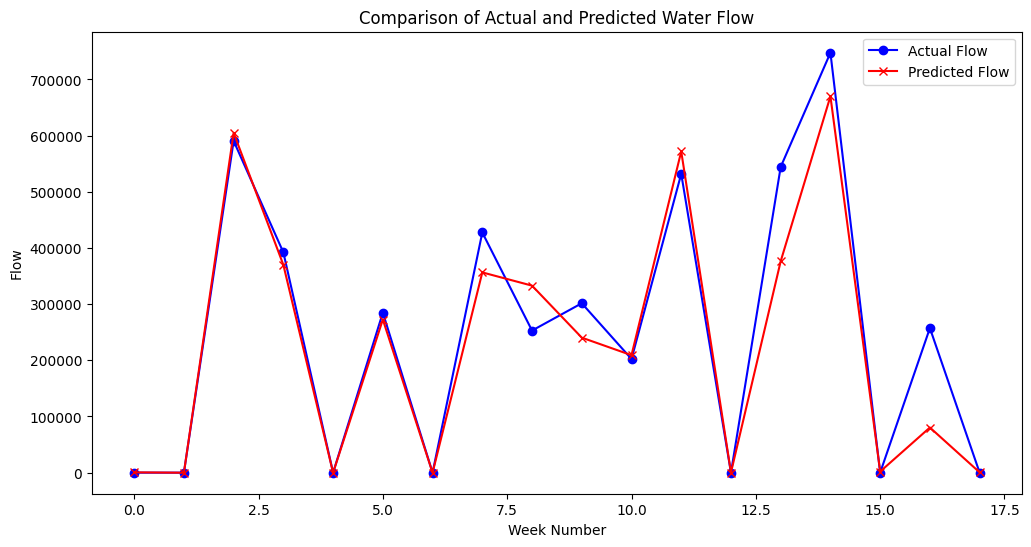

In [ ]:
import matplotlib.pyplot as plt

actual_values = y_test_weekly.to_numpy()

plt.figure(figsize=(12, 6))
plt.plot(actual_values, label='Actual Flow', marker='o',color='blue')
plt.plot(predictions_weekly, label='Predicted Flow', marker='x',color='red')

plt.title('Comparison of Actual and Predicted Water Flow')
plt.xlabel('Week Number')
plt.ylabel('Flow')
plt.legend()
plt.show()

In the visual comparison of predicted versus actual values, it is evident that the predicted values align closely with the actual values. This indicates a high degree of accuracy in the model's forecasts, as reflected in the proximity of the predicted data points to the real-world observations.

In [ ]:
# Sample input
input = {
    'rolling_mean': 451906.500000,   # Replace with an appropriate rolling mean value
    'rolling_std': 537271.641795,     # Replace with an appropriate rolling std value
    'lag_1': 39016.500000,          # Previous week's flow
    'lag_2': 1.059353e+06,          # Flow from two weeks ago
    'week_of_month': 4,    # Week number of the year
    'month': 8,            # Month
    'year': 2020           # Year
}

# Convert the sample input into a DataFrame
input_df = pd.DataFrame([input])

# Make a prediction
predicted_flow = model_weekly.predict(input_df)

# Display the predicted flow
print("Predicted Flow:", predicted_flow[0]/1000,"Litres")


Predicted Flow: 80.35834375 Litres


This sample prediction demonstrates the model's capability to assist users in forecasting weekly water usage. It offers a practical tool for anticipating consumption for a specified week, enhancing resource planning and management.